In [12]:
!pip install pandas numpy matplotlib seaborn ydata_profiling lightgbm scikit-learn

In [10]:
import pandas as pd

data_path =  "../data/r2/raw.csv"
data_train_path = "../data/r2/train.csv"
data_target_path = "../data/r2/target.csv"

In [8]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])

    return df

In [15]:
def prep_data(df):
    df = df.sort_values(by=['store_id', 'sku_id', 'date'])
    df['profit'] = df['net_sales'] - (df['units_sold'] * df['purchase_cost'])

    return df

## Data Splitting

In [16]:
def split_demand_data(df):
    df_unconstrained = df[df['stock_out_flag'] == 0].copy()
    df_censored = df[df['stock_out_flag'] == 1].copy()

    return df_unconstrained, df_censored

df = load_data(data_path)
df = prep_data(df)
df_train, df_target = split_demand_data(df)

df_train.to_csv(data_train_path, index=False)
df_target.to_csv(data_target_path, index=False)

## YdataProfiling

In [17]:
# from ydata_profiling import ProfileReport

# df = pd.read_csv("/home/nguyen-quang-huy/GITHUB/Dom Technology/datastorm/data/Retail/FMCG Multi-Country Sales Dataset/fmcg_sales_3years_1M_rows.csv")

# profile = ProfileReport(df, title="FMCG Sales Profiling", explorative=True)
# profile.to_file("fmcg_report.html")

## Main

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1274
[LightGBM] [Info] Number of data points in the train set: 977243, number of used features: 14
[LightGBM] [Info] Start training from score 60.608702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[639]	valid_0's l2: 483.361
Model saved successfully!


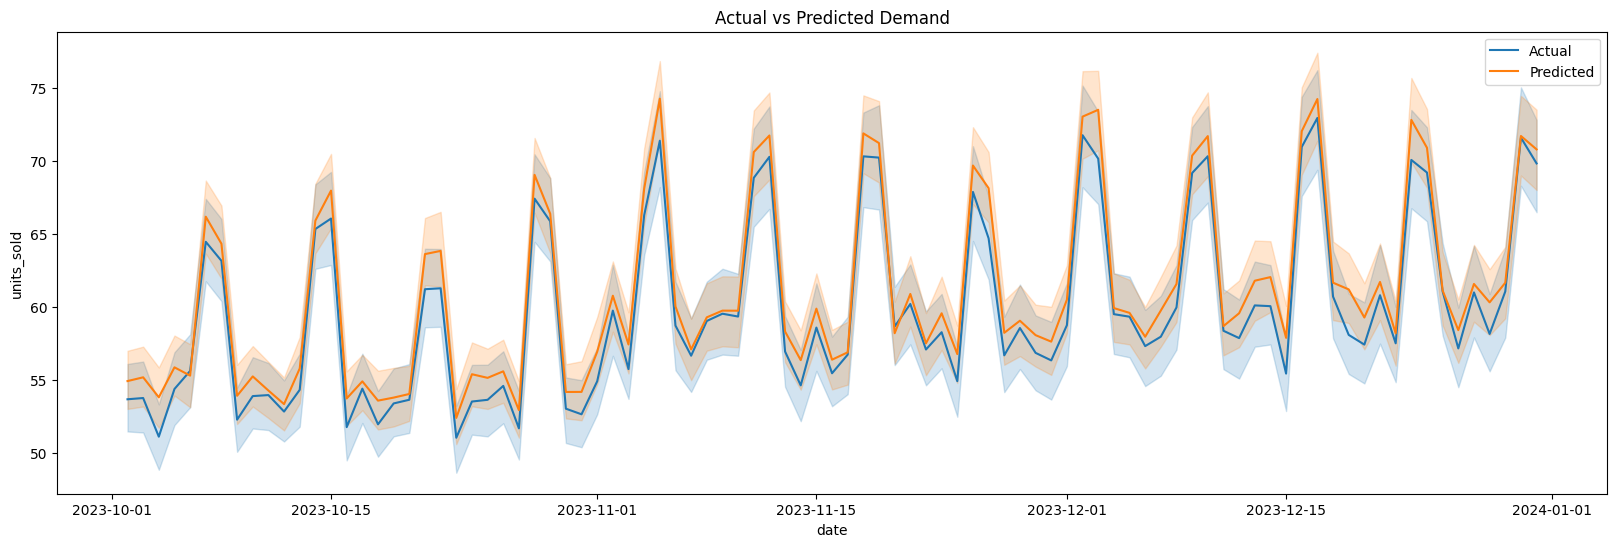

In [20]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

np.random.seed(42)

df = load_data(data_path)

def feature_engineering(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['store_id', 'sku_id', 'date'])
    df['units_sold_for_lag'] = df['units_sold']
    df.loc[df['stock_out_flag'] == 1, 'units_for_lag'] = np.nan
    df['units_for_lag'] = df.groupby(['store_id', 'sku_id'])['units_for_lag'].transform(
        lambda x: x.fillna(x.rolling(window=7, min_periods=1).mean())
    ).fillna(0)

    # Lag feature
    for lag in [1, 3, 7, 14, 28]:
        df[f'lag_{lag}'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(lag)

    df = df.drop(columns=['units_for_lag'])

    # Categorical encoding
    cats = ['store_id', 'city', 'sku_id', 'category', 'brand', 'weekday']
    for c in cats:
        if c in df.columns:
            df[c] = df[c].astype('category')

    return df

df_processed = feature_engineering(df)

train_mask = (df_processed['stock_out_flag'] == 0) & (df_processed['date'] < '2023-10-01')
val_mask = (df_processed['stock_out_flag'] == 0) & (df_processed['date'] >= '2023-10-01')

features = ['year', 'month', 'weekday', 'is_weekend', 'is_holiday',
            'temperature', 'rain_mm', 'list_price', 'discount_pct',
            'lag_7', 'lag_14', 'store_id', 'sku_id', 'category']

X_train = df_processed.loc[train_mask, features]
y_train = df_processed.loc[train_mask, 'units_sold']

X_val = df_processed.loc[val_mask, features]
y_val = df_processed.loc[val_mask, 'units_sold']

model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          callbacks=[lgb.early_stopping(stopping_rounds=50)])
joblib.dump(model, 'demand_forecast_model.pkl')
joblib.dump(features, 'model_features.pkl')
print("Model saved successfully!")

df_processed['predicted_demand'] = model.predict(df_processed[features])

df_temp = df_processed[df_processed['date'] > "2023-10-01"]
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_temp, x='date', y='units_sold', label='Actual')
sns.lineplot(data=df_temp, x='date', y='predicted_demand', label='Predicted')
plt.title('Actual vs Predicted Demand')
plt.show()

In [30]:
df = load_data(data_path)

import json
from collections import defaultdict

# Function to recursively convert sets to lists
def convert_sets_to_lists(obj):
    if isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, set):
        return sorted(list(obj))  # sorted for readability & stability
    else:
        return obj

# Initialize nested dictionary
hierarchy = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(set)
            )
        )
    )
)

# Iterate over rows to build hierarchy
for _, row in df.iterrows():
    city = row["city"]
    channel = row["channel"]
    store = row["store_id"]
    category = row["category"]
    subcategory = row["subcategory"]
    sku = row["sku_id"]

    hierarchy[city][channel][store][category][subcategory].add(sku)


In [28]:
print(hierarchy)

defaultdict(<function <lambda> at 0x7fe862864400>, {'Berlin': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7fe862864680>, {'Hypermarket': defaultdict(<function <lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x7fe862865bc0>, {'STORE0001': defaultdict(<function <lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x7fe8628658a0>, {'Personal Care': defaultdict(<class 'set'>, {'Shampoo': {'SKU0090', 'SKU0086', 'SKU0087'}, 'Soap': {'SKU0095', 'SKU0094', 'SKU0092', 'SKU0096', 'SKU0093'}, 'Toothpaste': {'SKU0098', 'SKU0099', 'SKU0101', 'SKU0097', 'SKU0100'}}), 'Beverages': defaultdict(<class 'set'>, {'Water': {'SKU0016', 'SKU0015', 'SKU0018', 'SKU0014', 'SKU0017'}, 'Soda': {'SKU0002', 'SKU0004', 'SKU0006', 'SKU0001'}, 'Juice': {'SKU0007', 'SKU0010', 'SKU0011', 'SKU0008', 'SKU0012'}, 'Energy drink': {'SKU0021', 'SKU0024', 'SKU0019', 'SKU0023', 'SKU0020'}}), 'Dairy': defaultdict(<class 'set'>, {'Yogurt': {'SKU0050', 'SKU0054', 'SKU0049', 'SKU0053', 'SKU0051'}, 'Cheese': {

In [31]:
# Convert hierarchy to JSON-friendly structure
hierarchy_json_ready = convert_sets_to_lists(hierarchy)
# Write hierarchy to JSON file
with open("hierarchy.json", "w", encoding="utf-8") as f:
    json.dump(
        hierarchy_json_ready,
        f,
        ensure_ascii=False,
        indent=2
    )


In [34]:
df = load_data(data_path)
df_temp = df[df['country'] == 'Germany']

print(len(df_temp))

175200


In [37]:
df = load_data(data_path)
df_temp = df[df['country'] == 'Italy']

print(len(df_temp))

350400


In [38]:
df_temp = df[df['country'] == 'Austria']

print(len(df_temp))

87600


In [39]:
df_temp = df[df['country'] == 'France']

print(len(df_temp))

87600


In [40]:
city_channel_count = (
    df.groupby("country")["sku_id"]
      .nunique()
      .reset_index(name="num_channels")
)


In [41]:
print(city_channel_count)

       country  num_channels
0      Austria            80
1       France            80
2      Germany            98
3        Italy           102
4  Netherlands            45
5       Poland            80
6        Spain           100


In [42]:
print(80*365*3)

87600


In [3]:
df = load_data(data_path)

df_temp = df[df['store_id'] == "STORE0001"]
df_temp.describe()

,date,year,month,day,weekofyear,weekday,is_weekend,is_holiday,temperature,rain_mm,...,list_price,discount_pct,promo_flag,gross_sales,net_sales,stock_on_hand,stock_out_flag,lead_time_days,purchase_cost,margin_pct
count,87600,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,...,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000
mean,2022-07-02 00:00:00.000000256,2022.000000,6.526027,15.720548,26.572603,3.005479,0.286758,0.013699,12.814995,2.904119,...,7.789000,0.015402,0.082500,490.959294,478.764907,299.447112,0.030103,6.505559,4.676760,0.384282
min,2021-01-01 00:00:00,2021.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.800000,0.000000,...,1.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.490000,-0.050000
25%,2021-10-01 00:00:00,2021.000000,4.000000,8.000000,14.000000,1.000000,0.000000,0.000000,10.610000,1.220000,...,4.540000,0.000000,0.000000,150.500000,148.640000,245.000000,0.000000,5.000000,2.550000,0.310000
50%,2022-07-02 00:00:00,2022.000000,7.000000,16.000000,27.000000,3.000000,0.000000,0.000000,12.840000,2.570000,...,6.945000,0.000000,0.000000,318.870000,314.315000,300.000000,0.000000,7.000000,4.300000,0.388000
75%,2023-04-02 00:00:00,2023.000000,10.000000,23.000000,40.000000,5.000000,1.000000,0.000000,15.000000,4.150000,...,11.792500,0.000000,0.000000,669.900000,655.960000,354.000000,0.000000,8.000000,6.840000,0.468000
max,2023-12-31 00:00:00,2023.000000,12.000000,31.000000,53.000000,6.000000,1.000000,1.000000,22.830000,11.580000,...,14.800000,0.300000,1.000000,5660.000000,4811.000000,664.000000,1.000000,15.000000,11.100000,0.550000
std,NaN,0.816501,3.447871,8.796297,15.051716,2.000460,0.452250,0.116237,3.371606,2.098998,...,4.247504,0.055519,0.275127,487.021010,465.466853,80.372615,0.170871,2.008712,2.664043,0.102590


In [19]:
df = load_data(data_path)
temp_df = df[df['sku_id'] == "SKU0001"]
numeric_cols = temp_df.select_dtypes(include=["int64", "float64"])

In [ ]:
'date', 'year', 'month', 'day', 'weekofyear', 'weekday', 'is_weekend',
       'is_holiday', 'temperature', 'rain_mm', 'store_id', 'country', 'city',
       'channel', 'latitude', 'longitude', 'sku_id', 'sku_name', 'category',
       'subcategory', 'brand','lead_time_days', 'supplier_id',

Index(['date', 'year', 'month', 'day', 'weekofyear', 'weekday', 'is_weekend',
       'is_holiday', 'temperature', 'rain_mm', 'store_id', 'country', 'city',
       'channel', 'latitude', 'longitude', 'sku_id', 'sku_name', 'category',
       'subcategory', 'brand', 'units_sold', 'list_price', 'discount_pct',
       'promo_flag', 'gross_sales', 'net_sales', 'stock_on_hand',
       'stock_out_flag', 'lead_time_days', 'supplier_id', 'purchase_cost',
       'margin_pct'],
      dtype='object')

In [20]:
corr_with_lead_time = (
    numeric_cols
    .corr()["lead_time_days"]
    .sort_values(ascending=False)
)

print(corr_with_lead_time)


lead_time_days    1.000000
latitude          0.014232
net_sales         0.006755
is_weekend        0.006467
units_sold        0.005613
gross_sales       0.005613
is_holiday        0.005550
temperature       0.004405
margin_pct        0.004213
stock_on_hand     0.003628
longitude         0.002953
weekofyear        0.001347
day              -0.000778
discount_pct     -0.001327
year             -0.002446
month            -0.002453
promo_flag       -0.004362
purchase_cost    -0.004498
stock_out_flag   -0.005078
weekday          -0.005781
rain_mm          -0.016214
list_price             NaN
Name: lead_time_days, dtype: float64
